In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image
import pickle

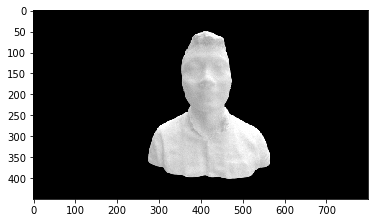

In [3]:
im = cv2.imread('data/1.tif', 0)

plt.imshow(im, cmap = 'gray')

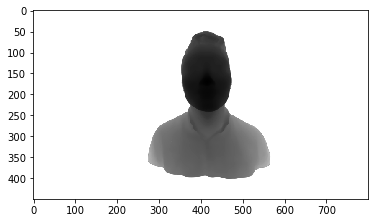

In [4]:
imz = cv2.imread('data/1z.tif', 0)

plt.imshow(imz, cmap = 'gray')

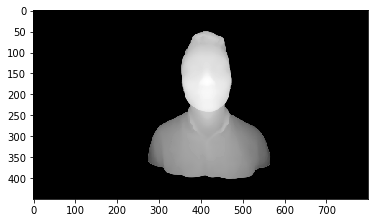

In [5]:
imzinv = 255 - imz

plt.imshow(imzinv, cmap = 'gray')

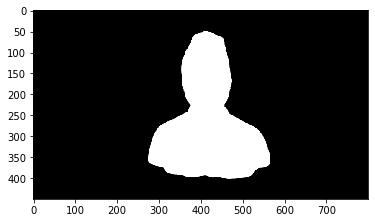

In [6]:
ima = cv2.imread('data/1a.tif', 0)

plt.imshow(ima, cmap = 'gray')

In [7]:
h, w = im.shape

In [8]:
print(im.shape)
print(imz.shape)

(450, 800)
(450, 800)


In [12]:
focalLength = 90.0
centerX = w / 2.0
centerY = h / 2.0
scalingFactor = 1000.0

Z = imzinv / scalingFactor

Xrang = np.arange(0,w,1)
Yrang = np.arange(0,h,1)
imXY = np.meshgrid(Xrang, Yrang)

print(imXY[0], imXY[1])
print(Z.shape)
print(imzinv.shape)

[[  0   1   2 ... 797 798 799]
 [  0   1   2 ... 797 798 799]
 [  0   1   2 ... 797 798 799]
 ...
 [  0   1   2 ... 797 798 799]
 [  0   1   2 ... 797 798 799]
 [  0   1   2 ... 797 798 799]] [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [447 447 447 ... 447 447 447]
 [448 448 448 ... 448 448 448]
 [449 449 449 ... 449 449 449]]
(450, 800)
(450, 800)


In [10]:


X = (imXY[0] - centerX) * Z / focalLength
Y = (imXY[1] - centerY) * Z / focalLength

Xworld = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
# def generate_pointcloud(rgb_file,depth_file,ply_file):

#     rgb = Image.open(rgb_file)
#     depth = Image.open(depth_file).convert('I')

#     if rgb.size != depth.size:
#         raise Exception("Color and depth image do not have the same 
# resolution.")
#     if rgb.mode != "RGB":
#         raise Exception("Color image is not in RGB format")
#     if depth.mode != "I":
#         raise Exception("Depth image is not in intensity format")


#     points = []    
#     for v in range(rgb.size[1]):
#         for u in range(rgb.size[0]):
#             color = rgb.getpixel((u,v))
#             Z = depth.getpixel((u,v)) / scalingFactor
#             print(Z)
#             if Z==0: continue
#             X = (u - centerX) * Z / focalLength
#             Y = (v - centerY) * Z / focalLength
#             points.append("%f %f %f %d %d %d 0\n"% 
                   
print(Xworld.shape)

(360000, 3)


In [11]:
Xworld

array([[-0., -0.,  0.],
       [-0., -0.,  0.],
       [-0., -0.,  0.],
       ...,
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

Text(0.5, 0.92, 'Recovered World Points')

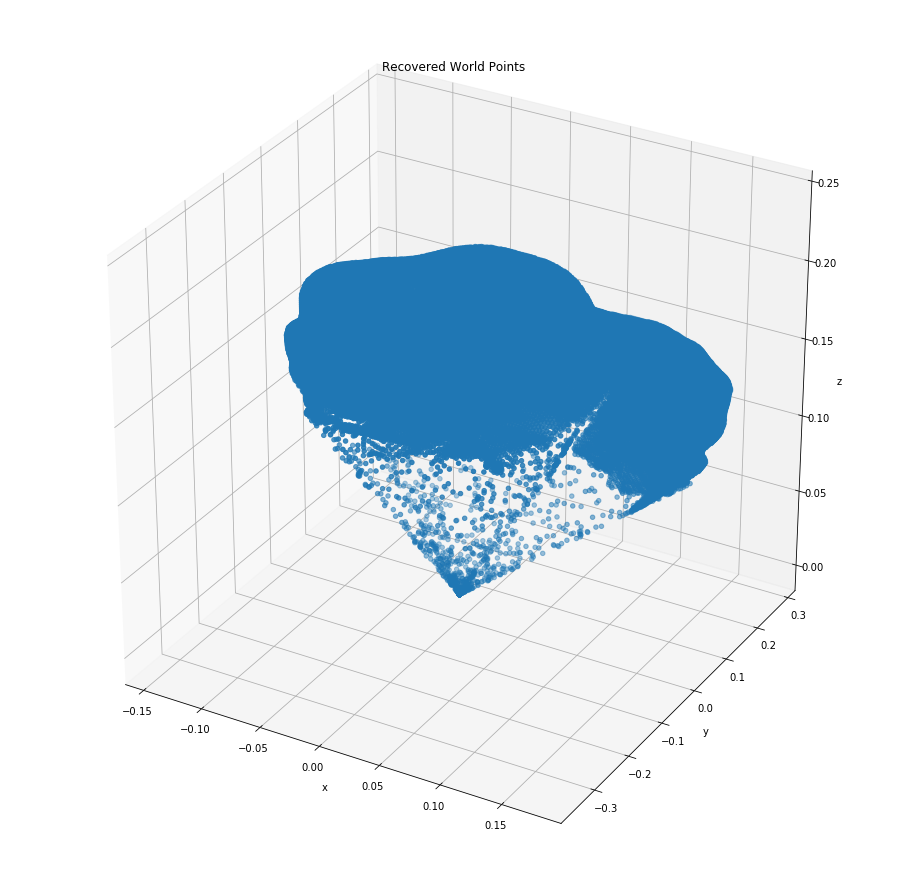

In [88]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')
ax.scatter(Xworld[:,0],Xworld[:,1],Xworld[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Recovered World Points')

In [89]:
points = []   

for index, i in enumerate(Xworld):
    points.append("%f %f %f %d %d %d 0\n"%(i[0],i[1],i[2], im.flatten()[index],im.flatten()[index],im.flatten()[index]))

ply_file = 'data/1.ply'   
file = open(ply_file,"w")
file.write('''ply
format ascii 1.0
element vertex %d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
property uchar alpha
end_header
%s
'''%(len(points),"".join(points)))
file.close()

In [90]:
pd.DataFrame(Xworld, columns = ['X', 'Y', 'Z'])

X    Y    Z
0      -0.0 -0.0  0.0
1      -0.0 -0.0  0.0
2      -0.0 -0.0  0.0
3      -0.0 -0.0  0.0
4      -0.0 -0.0  0.0
...     ...  ...  ...
359995  0.0  0.0  0.0
359996  0.0  0.0  0.0
359997  0.0  0.0  0.0
359998  0.0  0.0  0.0
359999  0.0  0.0  0.0

[360000 rows x 3 columns]

In [91]:
Xworldsmall = cv2.resize(Xworld.reshape(450,800,3),(9,16))

In [92]:
Xworldsmall.shape

(16, 9, 3)

In [93]:
Xworldsmallflat = Xworldsmall.reshape(Xworldsmall.shape[0]*Xworldsmall.shape[1], 3)

In [94]:
Xworldsmallflat.shape

(144, 3)

In [95]:
X = Xworld.reshape(450, 800, 3)

In [96]:
def get_mesh(X, Xflat):
    
    triangles = []
    uv = []
    vertices = []

    for i in range(X.shape[0] - 1):

        for j in range(X.shape[1]):

            curr = (i)*X.shape[1]+j
            right = (i)*X.shape[1]+j+1
            below = (i+1)*X.shape[1]+j
            left = (i+1)*X.shape[1]+j-1
            black = [0,0,0]
            
            curr_notblack = np.linalg.norm(Xflat[curr] - black) != 0
            right_notblack = np.linalg.norm(Xflat[right] - black) != 0
            below_notblack = np.linalg.norm(Xflat[below] - black) != 0
            left_notblack = np.linalg.norm(Xflat[left] - black) != 0
            
            if curr_notblack:
                vertices.append(Xflat[curr])
                uv.append([i,j])

            

            if j is 0:
                if curr_notblack and right_notblack and below_notblack:
                    triangles.append([curr, right,below ])
            elif j is X.shape[1]-1:
                if curr_notblack and below_notblack and left_notblack:
                    triangles.append([curr, below, left])
            else:
                if curr_notblack and right_notblack and below_notblack:
                    triangles.append([curr, right,below])
                if curr_notblack and below_notblack and left_notblack:
                    triangles.append([curr, below, left])
    
    i = X.shape[0] - 1
    for j in range(X.shape[1]):
        curr = (i)*X.shape[1]+j
        if curr_notblack:
                vertices.append(Xflat[curr])
                uv.append([i,j])
    
    
    
    return triangles, vertices, uv      
# pd.to_csv('meshDefinition.csv')


In [115]:
def get_mesh(X, Xflat):
    
    triangles = []
    uv = []
    vertices = []
    count = 0
    maps = {}
    
    for i in range(X.shape[0] - 1):

        for j in range(X.shape[1]):

            curr = (i)*X.shape[1]+j
            right = (i)*X.shape[1]+j+1
            below = (i+1)*X.shape[1]+j
            left = (i+1)*X.shape[1]+j-1
            black = [0,0,0]
            
            curr_notblack = np.linalg.norm(Xflat[curr] - black) != 0
            right_notblack = np.linalg.norm(Xflat[right] - black) != 0
            below_notblack = np.linalg.norm(Xflat[below] - black) != 0
            left_notblack = np.linalg.norm(Xflat[left] - black) != 0
            
            if curr_notblack:
                vertices.append(Xflat[curr])
                uv.append([i,j])
                maps[curr] = count
                count += 1

            

            if j is 0:
                if curr_notblack and right_notblack and below_notblack:
                    triangles.append([curr, right,below ])
            elif j is X.shape[1]-1:
                if curr_notblack and below_notblack and left_notblack:
                    triangles.append([curr, below, left])
            else:
                if curr_notblack and right_notblack and below_notblack:
                    triangles.append([curr, right,below])
                if curr_notblack and below_notblack and left_notblack:
                    triangles.append([curr, below, left])
    
    i = X.shape[0] - 1
    for j in range(X.shape[1]):
        curr = (i)*X.shape[1]+j
        if curr_notblack:
                vertices.append(Xflat[curr])
                uv.append([i,j])
    
    
    
    return triangles, vertices, uv , maps

In [116]:
triangles, vertices, uv, maps = get_mesh(X, Xworld)

In [111]:
tri = pd.DataFrame(np.array(triangles).flatten(), columns = ['X'])
len(tri['X'].unique())

56925

In [120]:
trgles = pd.DataFrame(triangles, columns = ['one', 'two', 'three'])

for row in trgles.iterrows():
    row[1]['one'] = maps[row[1]['one']]
    row[1]['two'] = maps[row[1]['two']]
    row[1]['three'] = maps[row[1]['three']]

trgles

one    two  three
0           1      2     10
1           1     10      9
2           2      3     11
3           2     11     10
4           3     12     11
...       ...    ...    ...
112614  56895  56923  56922
112615  56896  56897  56924
112616  56896  56924  56923
112617  56897  56898  56925
112618  56897  56925  56924

[112619 rows x 3 columns]

In [99]:
vts = np.array(vertices)
uvs = np.array(uv)

pts = np.hstack((vts, uvs))

In [100]:
points = pd.DataFrame(vts, columns = ['x','y','z'])
uvdefs = pd.DataFrame(uvs, columns = ['u','v'])

In [101]:
x = [1,1,1]
y = [1,1,1]

print(x == y)

True


In [121]:
trgles.to_csv('triangles.csv')
points.to_csv('points.csv')
uvdefs.to_csv('uvs.csv')

In [49]:
len(vertices)

20

In [50]:
len(uv)

20

In [32]:
black = [0.0, 0.0, 0.0]
print(np.linalg.norm(Xworldsmallflat[0] - black) == 0)

True


In [37]:
Xworldsmallflat

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   